<table style="width: 100%;"> <tr> <td style="width: 20%; vertical-align: top;"> <img src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" alt="UdeA" height="150px"> </td> <td style="width: 80%; padding-left: 20px;"> <strong style="font-size: 30px;">EXPLORACIÓN DEL CONJUNTO DE DATOS PARA EL DESARROLLO DE UN SISTEMA DE RECOMENDACIÓN DE PELÍCULAS - PROYECTO MARKETING</strong><br><br> <span style="font-size: 30px;"> Luisa Fernanda Alzate Cuartas <br> Juan Camilo Henao Caro<br>Isabella Mendez Hoyos<br> Fernando Antonio Piñeres Ramos </span> </td> </tr> </table>

#### LIBRERÍAS REQUERIDAS

In [28]:
#Conexión de Google Colab con Drive.
from google.colab import drive
drive.mount('/content/drive')

#Acceder a los archivos de la carpeta marketing para el uso de funciones.
import sys
sys.path.append('/content/drive/MyDrive/marketing/Marketing')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import pandas as pd # Manipulación y el analísis de datos.
import sqlite3 as sql # Interactuar con base de datos SQL usando Python.
from sklearn.preprocessing import MultiLabelBinarizer

#### CONEXIÓN CON LA BASE DE DATOS

In [30]:
#Establece una conexión a la base de datos SQLite ubicada en "content/db_movies"
conexion = sql.connect("/content/drive/MyDrive/marketing/Marketing/db_movies")

# Crear un cursor a partir de la conexión, que permita ejecutar comando SQL sobre la base de datos.
cur = conexion.cursor()

In [31]:
# Ejecuta una consulta SQL que obtiene los nombres de todas las tablas existentes en la base de datos.
cur.execute("SELECT name FROM sqlite_master where type='table' ")

# Recupera todos los resultados de la consulta anterior en forma de lista de tuplas.
cur.fetchall()

[('ratings',), ('movies',)]

#### EXPLORACIÓN DE LAS TABLAS

##### TABLA MOVIES

In [32]:
# Ejecuta la consulta SQL "SELECT * FROM movies" sobre la base de datos y carga los resultados en un DataFrame de pandas.
table_movies = pd. read_sql_query("SELECT * FROM movies", conexion)
table_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy





```
# Transformaciones requeridas en la tabla movies
  - Separar el nombre de la película y el año de estreno.
  - Separación de los generos.
```





In [55]:
separacion = """SELECT movieId, genres, TRIM(SUBSTR(title, 1, LENGTH(title) - 7)) AS titulo, SUBSTR(title, -5, 4) AS año FROM movies WHERE title LIKE '%(____)'; """

table_movies = pd.read_sql_query(separacion, conexion)
table_movies.head()

,movieId,genres,titulo,año
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Adventure|Children|Fantasy,Jumanji,1995
2,3,Comedy|Romance,Grumpier Old Men,1995
3,4,Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Comedy,Father of the Bride Part II,1995


In [34]:
# confirmar que quedó bien la separacion
# pd.set_option('display.max_rows', len(table_movies))
# display(table_movies)

In [35]:
table_movies['genres'] = table_movies['genres'].str.split('|')

# Creamos el binarizador que convertirá las listas de géneros en columnas con 0 y 1
mlb = MultiLabelBinarizer()

# Aplicamos el binarizador a la columna 'genero' que contiene listas
generos_bin = mlb.fit_transform(table_movies['genres'])

# Creamos un nuevo DataFrame con esa matriz y ponemos como nombres de columna los géneros encontrados
df_generos = pd.DataFrame(generos_bin, columns=mlb.classes_)

# Unimos el DataFrame original (df_movies) con el nuevo DataFrame de géneros binarizados
df_movies = pd.concat([table_movies, df_generos], axis=1)

# DataFrame final con las nuevas columnas ya agregadas
display(df_movies.head())

,movieId,genres,titulo,año,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story,1995,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,"[Adventure, Children, Fantasy]",Jumanji,1995,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,"[Comedy, Romance]",Grumpier Old Men,1995,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,"[Comedy, Drama, Romance]",Waiting to Exhale,1995,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,[Comedy],Father of the Bride Part II,1995,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
# Eliminamos la columna 'genres' porque ya no es necesaria
df_movies = df_movies.drop(columns=['genres'])

display(df_movies)


Output hidden; open in https://colab.research.google.com to view.

In [37]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9718 entries, 0 to 9717
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   movieId             9718 non-null   int64 
 1   titulo              9718 non-null   object
 2   año                 9718 non-null   object
 3   (no genres listed)  9718 non-null   int64 
 4   Action              9718 non-null   int64 
 5   Adventure           9718 non-null   int64 
 6   Animation           9718 non-null   int64 
 7   Children            9718 non-null   int64 
 8   Comedy              9718 non-null   int64 
 9   Crime               9718 non-null   int64 
 10  Documentary         9718 non-null   int64 
 11  Drama               9718 non-null   int64 
 12  Fantasy             9718 non-null   int64 
 13  Film-Noir           9718 non-null   int64 
 14  Horror              9718 non-null   int64 
 15  IMAX                9718 non-null   int64 
 16  Musical             9718

In [38]:
df_movies.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,9718.0,42003.423750,52026.997240,1.0,3240.25,7261.5,75804.5,193609.0
(no genres listed),9718.0,0.002573,0.050658,0.0,0.00,0.0,0.0,1.0
Action,9718.0,0.187384,0.390240,0.0,0.00,0.0,0.0,1.0
Adventure,9718.0,0.129656,0.335942,0.0,0.00,0.0,0.0,1.0
Animation,9718.0,0.062359,0.241818,0.0,0.00,0.0,0.0,1.0
Children,9718.0,0.068224,0.252143,0.0,0.00,0.0,0.0,1.0
Comedy,9718.0,0.386191,0.486900,0.0,0.00,0.0,1.0,1.0
Crime,9718.0,0.123173,0.328653,0.0,0.00,0.0,0.0,1.0
Documentary,9718.0,0.045277,0.207921,0.0,0.00,0.0,0.0,1.0
Drama,9718.0,0.448240,0.497339,0.0,0.00,0.0,1.0,1.0


In [39]:
df_movies.describe(include='object').T

,count,unique,top,freq
titulo,9718,9437,Hamlet,5
año,9718,106,2002,311


In [40]:
df_movies.isnull().sum()

,0
movieId,0
titulo,0
año,0
(no genres listed),0
Action,0
Adventure,0
Animation,0
Children,0
Comedy,0
Crime,0


In [41]:
total_observaciones = df_movies.size
total_nulos = df_movies.isnull().sum().sum()
porcentaje_nulos = (total_nulos / total_observaciones) * 100
print(f" el porcentaje de datos nulos de la base de datos de movies es: {porcentaje_nulos:.2f}%")

 el porcentaje de datos nulos de la base de datos de movies es: 0.00%


In [42]:


duplicados = df_movies.duplicated().sum()
print(f"Cantidad de duplicados: {duplicados}")


Cantidad de duplicados: 0


Transformaciones necesarias para la tabla movies: separar de la columna title el nombre de la película de la fecha de estreno y separar los generos.

In [52]:
# pd.read_sql_query("""
# select * from movies where title like '%Goodnight Mommy%'

# """, conexion)


##### TABLA RATINGS

In [44]:
# Ejecuta la consulta SQL "SELECT * FROM ratings" sobre la base de datos y carga los resultados en un DataFrame de pandas.
table_ratings = pd.read_sql_query("SELECT * FROM ratings", conexion)
table_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Transformaciones necesarias para la tabla ratings: Transformar la columna timestamp en formato fecha.

In [45]:
table_ratings['timestamp'] = pd.to_datetime(table_ratings['timestamp'], unit='s')


table_ratings['day'] = table_ratings['timestamp'].dt.day
table_ratings['month'] = table_ratings['timestamp'].dt.month
table_ratings['hour'] = table_ratings['timestamp'].dt.hour
table_ratings['year'] = table_ratings['timestamp'].dt.year



if 'date' in table_ratings.columns:
  table_ratings = table_ratings.drop('date', axis=1)

# Mostrar el DataFrame actualizado
display(table_ratings.head())


,userId,movieId,rating,timestamp,day,month,hour,year
0,1,1,4.0,2000-07-30 18:45:03,30,7,18,2000
1,1,3,4.0,2000-07-30 18:20:47,30,7,18,2000
2,1,6,4.0,2000-07-30 18:37:04,30,7,18,2000
3,1,47,5.0,2000-07-30 19:03:35,30,7,19,2000
4,1,50,5.0,2000-07-30 18:48:51,30,7,18,2000


In [46]:
# Eliminamos la columna 'timestamp' porque ya no es necesaria
table_ratings.drop(columns=['timestamp'], inplace=True)

display(table_ratings)

,userId,movieId,rating,day,month,hour,year
0,1,1,4.0,30,7,18,2000
1,1,3,4.0,30,7,18,2000
2,1,6,4.0,30,7,18,2000
3,1,47,5.0,30,7,19,2000
4,1,50,5.0,30,7,18,2000
...,...,...,...,...,...,...,...
100831,610,166534,4.0,3,5,21,2017
100832,610,168248,5.0,3,5,22,2017
100833,610,168250,5.0,8,5,19,2017
100834,610,168252,5.0,3,5,21,2017


In [47]:
table_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   day      100836 non-null  int32  
 4   month    100836 non-null  int32  
 5   hour     100836 non-null  int32  
 6   year     100836 non-null  int32  
dtypes: float64(1), int32(4), int64(2)
memory usage: 3.8 MB


In [48]:
table_ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
day,0
month,0
hour,0
year,0


In [49]:
table_ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100836.0,326.127564,182.618491,1.0,177.0,325.0,477.0,610.0
movieId,100836.0,19435.295718,35530.987199,1.0,1199.0,2991.0,8122.0,193609.0
rating,100836.0,3.501557,1.042529,0.5,3.0,3.5,4.0,5.0
day,100836.0,15.854367,8.808642,1.0,8.0,16.0,23.0,31.0
month,100836.0,6.413811,3.400786,1.0,4.0,6.0,9.0,12.0
hour,100836.0,12.609167,7.337549,0.0,6.0,14.0,19.0,23.0
year,100836.0,2007.722936,6.890376,1996.0,2002.0,2007.0,2015.0,2018.0


In [50]:
table_ratings.duplicated().sum()
print(f"los duplicados de la tabal ratings son {table_ratings.duplicated().sum()}")

los duplicados de la tabal ratings son 0


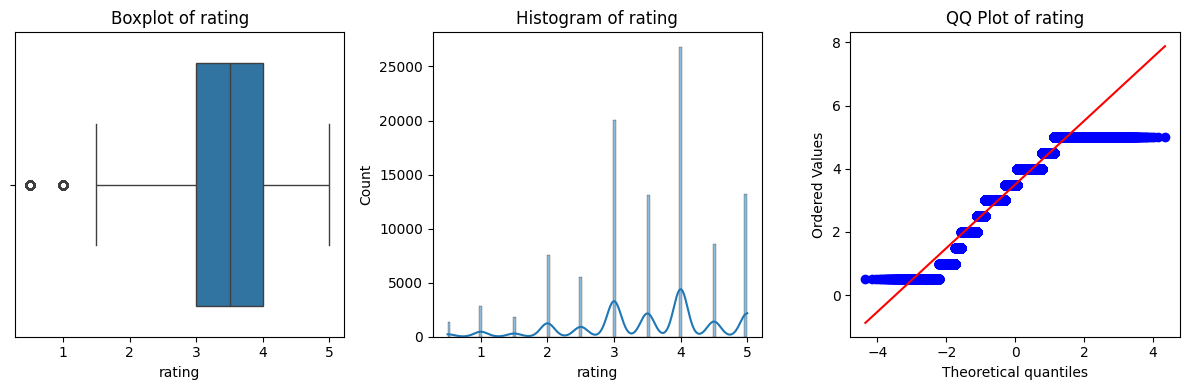

NameError: name 'skew' is not defined

In [53]:


import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

for col in ['rating', 'day', 'month', 'hour', 'year']:
    plt.figure(figsize=(12, 4))
    # Boxplot
    plt.subplot(1, 3, 1)
    sns.boxplot(x=table_ratings[col])
    plt.title(f'Boxplot of {col}')
    # Histogram
    plt.subplot(1, 3, 2)
    sns.histplot(table_ratings[col], kde=True)
    plt.title(f'Histogram of {col}')
    # QQ Plot
    plt.subplot(1, 3, 3)
    probplot(table_ratings[col], dist="norm", plot=plt)
    plt.title(f'QQ Plot of {col}')
    plt.tight_layout()
    plt.show()
    # Calculate and print skewness and kurtosis
    print(f"Skewness of {col}: {skew(table_ratings[col])}")
    print(f"Kurtosis of {col}: {kurtosis(table_ratings[col])}")


#### PREGUNTAS PARA EXPLORACIÓN GENERAL

¿Cuántas películas hay registradas en total?

¿Cuántos géneros diferentes existen?

¿Cuál es el género más común entre las películas?

¿Cuántas calificaciones (ratings) hay en total?

¿Cuántos usuarios distintos han dado calificaciones?

¿Qué película tiene más calificaciones?

¿Qué usuario ha dado más calificaciones?

¿Cuál es la distribución de las calificaciones? (¿hay más 5.0, 4.0, etc.?)

¿Existen películas sin ninguna calificación?

¿Cuál es el promedio de calificación por película?

¿Cuál es el promedio de calificación por usuario?

¿Cuál es el rango de años de las películas? (¿de qué año a qué año?)

#### PREGUNTAS PARA DETENCCIÓN DE PROBLEMAS O CALIDAD DE DATOS

¿Hay películas con el mismo nombre pero diferente movieId?

¿Hay calificaciones fuera del rango esperado (por ejemplo, menores a 0 o mayores a 5)?

¿Existen valores nulos o vacíos en alguna columna?

¿Hay géneros desconocidos o no estandarizados?

¿Hay películas sin año de estreno?

#### PREGUNTAS PARA VISUALIZACIÓN DE DISTRIBUCIONES

Cómo es la distribución de las calificaciones?

¿Cómo es la distribución del número de calificaciones por película?

¿Cómo es la distribución del número de calificaciones por usuario?

¿Cómo varía la calificación promedio a lo largo de los años?

#### PREGUNTA ANÁLISIS AVANZADO



(Cruzar tablas y buscar patrones)

¿Cuál es el género que tiene mejores calificaciones promedio?

¿Las películas más recientes tienen mejores calificaciones que las antiguas?

¿Qué usuarios tienden a calificar más bajo o más alto?

¿Hay algún patrón entre género y año de estreno?

¿Cuál es la película mejor calificada?

¿Cuál es la película peor calificada?

¿Existe algún año donde se estrenaron muchas películas de un género específico?

¿Cómo cambia la popularidad de géneros a lo largo del tiempo?